# Stick&Slip

On pose  les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\gamma = \frac{ \mu d_c}{b \sigma H}$$

On trouve :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\bar{\Psi}[e^{\varphi}] - \gamma(\bar{v_m}-1)) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

Avec l'adimensionnement suivant : $$\bar \Psi = L_b \cdot \Psi$$

$$\Psi : v \mapsto \mathcal{K} * v$$

En définissant le noyau $\mathcal{K}$ par sa transformée de Fourier :

$$\mathcal{F}(\mathcal{K}) : k \mapsto |k| \frac{1+e^{-4|k|H}}{1-e^{-4|k|H}} = \frac{|k|}{\tanh(2|k|H)} $$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import special
from scipy import integrate
import pandas as pd

In [76]:
def noyau(freq,H) :
    pos = freq==0 #on localise la position des zéros
    freq[pos] = 1 #On remplace les zéros par des non-zéros (1 par exemple)
    c = np.abs(freq)
    freq = c/np.tanh(2*H*c) #on applique l'opération (sans rencontrer de zéros donc)
    freq[pos] = 0 #on met des zéros aux positions des zéros du tableau de départ
    return freq

def Psi(f, deltaX, H) :
    F=np.fft.fft(f)
    freq=np.fft.fftfreq(len(f),deltaX)*2*np.pi
    K = noyau(freq, H)
    F=K*F
    psi=np.fft.ifft(F)
    return psi.real*Lb

def F(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    D = v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(len(x)))
    phid1 = D/(alpha1 + beta*v)
    phid2 = D/(alpha2 + beta*v)
    phidot = np.concatenate((phid1[0:K1], phid2[K1:K2+1], phid1[K2+1:]))
    nudot = 1/theta - v
    return np.array([phidot, nudot])

def G(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    phidot = (v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1)))/(alpha1+beta*v)
    nudot = 1/theta - v
    return np.array([phidot, nudot])

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K + 1
        s = (tol / (2 * erreur))**0.25
        print(erreur)
        if erreur < tol:
            return ykk, s*h
        if s*h < dtmin:
            return ykk, h
        h = s*h
    if K==30 and erreur == tol:
        raise ValueError("Trop d'iterations")
    return ykk, h

In [100]:
##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a1 = 2e-3
a2 = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

deltaX = int(Lb/4)
N = 10000
I = 2**9
L = I * deltaX
H = 2*L
h = 1e-2

d = L//20
K1 = (L//2-d)//deltaX
K2 = (L//2+d)//deltaX

alpha1 = a1/b 
alpha2 = a2/b
beta = eta*v0/(b*sigma) #=6e-08
gamma = mu*dc/(b*sigma*H)

#Conditions initiales
x = np.arange(-L//2, L//2 + 1, deltaX)
temps = np.array([0])
amp = 1
CI = amp*np.ones(len(x))

phik = np.log(CI)
nuk = np.log(1/CI)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    if n%pas == 0:
        print(n)
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    temps = np.concatenate((temps, [temps[n]+h]))
    Phi.append(yk[0])
    Nu.append(yk[1])

0
2.354474173127287e-19
1.7648935890958117e-10
3.0003169754372014e-11
2.2873590975542866e-06
5.450634041687303e-13
4.031224213540353e-11
1.1033285444674195e-09
1.468793664023227e-11
2.7867588049328522e-11
1.4661626680591386e-10
3.277000115143785e-11
6.922930339922879e-11
9.517621975853018e-11
5.36322485850024e-11
2.5377890210876182e-11
3.011514441894732e-11
7.989659085315335e-11
1.1162180532842046e-10
3.684931592286344e-11
2.2592363683227376e-11
4.5072576825908473e-11
1.1004878141927937e-10
3.6862306650611475e-11
4.420207274283139e-11
6.475466354575444e-11
6.68007278756049e-11
4.557330321350842e-11
3.414358985259848e-11
4.4157284348627724e-11
7.048257698253551e-11
7.059358302620959e-11
4.3330146496458644e-11
3.106179011234512e-11
4.454568947626156e-11
7.875689579059936e-11
7.51107232113593e-11
4.024829598661066e-11
2.742589511229473e-11
4.536065683526757e-11
9.068337480499931e-11
8.011514308140432e-11
3.6012971819265763e-11
2.3117148628112733e-11
4.70983257476883e-11
1.1011042714388497

4.657672989612831e-11
4.661706801473812e-11
4.667065613888332e-11
4.6738806732611774e-11
4.682361395589608e-11
4.6922820333262407e-11
4.7039527410398744e-11
4.71720923602708e-11
4.7323922562721575e-11
4.749675393596427e-11
4.769233181296994e-11
4.791409808494293e-11
4.816485606717211e-11
4.8440563331592007e-11
4.874134805721445e-11
4.9057644547475886e-11
4.9380297148042794e-11
4.9694340882022955e-11
4.998690518064615e-11
5.024590709283648e-11
5.0463603965211174e-11
5.063744842164608e-11
5.076634420880861e-11
5.085460863117126e-11
5.0908055308317844e-11
5.0931628436984733e-11
5.093174059017744e-11
5.0912564404027176e-11
5.0880034002338934e-11
5.0838154033613133e-11
5.0787497692618763e-11
5.0732095755534515e-11
5.067407000965006e-11
5.0613466776646983e-11
5.05516913770622e-11
5.0490563237904466e-11
5.042815212799243e-11
5.0368215122401534e-11
5.0308437406116485e-11
5.0248410283877556e-11
5.0191440606319506e-11
5.013368818415464e-11
5.00780719551678e-11
5.002385188335928e-11
4.99699002306

5.1218576620705123e-11
5.118655614326342e-11
5.115417125949091e-11
5.112235153421619e-11
5.1091204884613086e-11
5.1059722072863785e-11
5.102935693196122e-11
5.099849053114044e-11
5.096807351511863e-11
5.093807889216836e-11
5.0908675688596724e-11
5.087813037547151e-11
5.0849176166881136e-11
5.0819606500304526e-11
5.0790085875790047e-11
5.076138204005075e-11
5.073241438234031e-11
5.0703329513351893e-11
5.067427355513624e-11
5.064566000463701e-11
5.061683811256845e-11
5.058818520662366e-11
5.055996654425925e-11
5.053122690494239e-11
5.050168827525774e-11
5.047422794194251e-11
5.0445607462303575e-11
5.041601012430684e-11
5.0388258096360514e-11
5.035858634411532e-11
5.033038986538458e-11
5.030093615256808e-11
5.0271996877307706e-11
5.0242562144916374e-11
5.021348080990814e-11
5.01835679688914e-11
5.0153341823067094e-11
5.012353895851692e-11
5.009270437146621e-11
5.006190878853772e-11
5.003047614979622e-11
4.999880237322362e-11
4.996617412133297e-11
4.993338909984996e-11
4.989894038578834e-1

5.7918529818721375e-11
5.79466817892655e-11
5.797719092841394e-11
5.800379248228481e-11
5.803461971229908e-11
5.8061651630118035e-11
5.808901337395889e-11
5.811833289114859e-11
5.814598052784408e-11
5.8174870409677856e-11
5.820383099686702e-11
5.82319474832607e-11
5.825832193312372e-11
5.828652978836923e-11
5.831709654272613e-11
5.834139154249637e-11
5.837306237779295e-11
5.840040805903462e-11
5.842591790958268e-11
5.845514582197005e-11
5.848345065606432e-11
5.850786712024602e-11
5.853455569457994e-11
5.856046946837701e-11
5.858775505445191e-11
5.861073247006009e-11
5.863688944434363e-11
5.865965918316964e-11
5.86848348421919e-11
5.870441675690285e-11
5.872858929321494e-11
5.874880987199345e-11
5.876865101534064e-11
5.878932041614024e-11
5.88077146440876e-11
5.8827644385457e-11
5.884288688690344e-11
5.885914748598256e-11
5.887574130898289e-11
5.889163357855953e-11
5.890568919587769e-11
5.891921819367623e-11
5.893177547975264e-11
5.894340684926289e-11
5.895808675305586e-11
5.89654957462

5.125621951218296e-11
5.1069548036435305e-11
5.089821005103875e-11
5.074690322169097e-11
5.0598544728521764e-11
5.047777802646782e-11
5.0351886138387287e-11
5.02549383583789e-11
5.0147033340929956e-11
5.0055058557993265e-11
4.9975617320720976e-11
4.990067673296856e-11
4.982125712877133e-11
4.9759956233513706e-11
4.9701022471561084e-11
4.9639621291765366e-11
4.958952724671355e-11
4.954291760559172e-11
4.949109551769694e-11
4.944996737805527e-11
4.940877883647921e-11
4.9370959388059775e-11
4.933696710909532e-11
4.930207295424065e-11
4.9268836712749237e-11
4.924174925959851e-11
4.920867301925052e-11
4.918746429285174e-11
4.915771018817918e-11
4.913889864973427e-11
4.911068203815841e-11
4.909268016431672e-11
4.906770692950275e-11
4.905631988934852e-11
4.9028122247442724e-11
4.901887815644906e-11
4.899887708572096e-11
4.8980765012922316e-11
4.8966234900921816e-11
4.89534834122199e-11
4.8939527888711624e-11
4.89247997229315e-11
4.891368179292884e-11
4.889856051085982e-11
4.889182891070538e-1

4.8832651914957025e-11
4.887130145386434e-11
4.8917068440604194e-11
4.894922161873747e-11
4.8990527566859814e-11
4.9009676337960395e-11
4.903967351581925e-11
4.9061093933179156e-11
4.907214882284284e-11
4.9083883049612463e-11
4.909173882812079e-11
4.9090812578982406e-11
4.9091739672581626e-11
4.908163504252773e-11
4.9070839974702185e-11
4.9047958477976506e-11
4.903963612970723e-11
4.901523761298006e-11
4.8994354638013424e-11
4.8966209043474114e-11
4.8937820208406885e-11
4.890885738853505e-11
4.8876409058096454e-11
4.8848992557273993e-11
4.881529908917901e-11
4.87824378960098e-11
4.874062103858542e-11
4.8715005676545465e-11
4.8677232503490484e-11
4.8636939122738265e-11
4.859014134773192e-11
4.856125773512948e-11
4.850683169582916e-11
4.846756838627083e-11
4.841650517432308e-11
4.8361309573305616e-11
4.830022316893791e-11
4.823290277176462e-11
4.8168239325937885e-11
4.808208588672487e-11
4.799294242247825e-11
4.790586229183698e-11
4.7794833181183246e-11
4.76995197935559e-11
4.76044460629

6.169483946657995e-11
6.540994868628364e-11
6.258419455547531e-11
5.976075821458114e-11
5.761751283143834e-11
5.6029369939482766e-11
5.480401587035191e-11
5.383615868642501e-11
5.3048706056890086e-11
5.239300124968675e-11
5.1850079424722976e-11
5.13737779798645e-11
5.097203705275907e-11
5.061384208774079e-11
5.0310133478685386e-11
5.003682497281618e-11
4.980345619709334e-11
4.9587544191308326e-11
4.9410356697932025e-11
4.924260566821745e-11
4.9105876020778567e-11
4.8980197649766507e-11
4.8872764054115785e-11
4.8783931772908736e-11
4.870311598818646e-11
4.863372566557048e-11
4.857793643086564e-11
4.852402855357506e-11
4.848988124779961e-11
4.845489018005413e-11
4.8425346922614446e-11
4.839907941226013e-11
4.8381505852581663e-11
4.836385340397111e-11
4.835507253310385e-11
4.833682335509293e-11
4.8327241294613e-11
4.832013059093558e-11
4.8309886501879104e-11
4.830163826454262e-11
4.8299352972215377e-11
4.8295325922769837e-11
4.8291774871815626e-11
4.8301691593451e-11
4.831750151563242e-11

4.819236540042901e-11
4.8170106584146325e-11
4.814620452221044e-11
4.81291774633689e-11
4.810910193971862e-11
4.812898401703037e-11
4.820216954251257e-11
4.840375567881346e-11
4.883131005945497e-11
4.960891844170783e-11
5.083497744202197e-11
5.2436993803637125e-11
5.409508291195124e-11
5.5375624469063876e-11
5.611286454825675e-11
5.632678197377893e-11
5.6209363709444596e-11
5.591509924844254e-11
5.5535643747899714e-11
5.512826269281168e-11
5.4744719217028385e-11
5.436786559999624e-11
5.3999274109218416e-11
5.3685814068322655e-11
5.337583195832137e-11
5.3091046537024786e-11
5.283160499806872e-11
5.2578987199455765e-11
5.235222035460893e-11
5.214081614129167e-11
5.1933154817179424e-11
5.174154527850784e-11
5.156138259885426e-11
5.1392009699809945e-11
5.1220893657458095e-11
5.105933945459063e-11
5.091304007481021e-11
5.07599934096898e-11
5.061966679152556e-11
5.0493983789097505e-11
5.03750633635245e-11
5.025857087653034e-11
5.016650106352539e-11
5.0079743089195225e-11
5.0018538074968925e-

4.826579120953861e-11
4.823180368439876e-11
4.8190213368622614e-11
4.813492726460056e-11
4.810834443385535e-11
4.806106439531344e-11
4.8028133785287723e-11
4.7988587483927386e-11
4.794694872451082e-11
4.7920451299768047e-11
4.7885434008495445e-11
4.783806453262791e-11
4.782175330704415e-11
4.779055416008693e-11
4.7758719859623394e-11
4.773350971023673e-11
4.770386707101575e-11
4.769826369836197e-11
4.7669906670850914e-11
4.7652299226167265e-11
4.766670516970712e-11
4.7666412848526485e-11
4.767823012886814e-11
4.7719509312452915e-11
4.776997541787013e-11
4.784540607928037e-11
4.7972505369624243e-11
4.8118618272016136e-11
4.8318490950363666e-11
4.8571573751329976e-11
4.884161375331087e-11
4.9124514858267775e-11
4.9388096426349234e-11
4.9552581503773424e-11
4.9576098255967197e-11
4.941480218944056e-11
4.900039258124979e-11
4.831499455576732e-11
4.7290487346885275e-11
4.585633365929741e-11
4.3975339165357143e-11
4.1900755532197926e-11
4.2330250691532524e-11
5.549931812623809e-11
7.13668773

5.130277841559027e-11
5.1146616225268943e-11
5.1003798793057726e-11
5.087823642453419e-11
5.073995279105207e-11
5.061354972758376e-11
5.0502384143625774e-11
5.0382619708420416e-11
5.027840113077223e-11
5.017769468081359e-11
5.006387805757675e-11
4.997259380306737e-11
4.9877897585647526e-11
4.97845035779574e-11
4.970238490909211e-11
4.9610181695429816e-11
4.953671689602371e-11
4.945593230467393e-11
4.9380883277293993e-11
4.9294749326859404e-11
4.9235227842038754e-11
4.915784516926317e-11
4.9099612012036266e-11
4.902112076290022e-11
4.896129536452937e-11
4.8895183111255e-11
4.88375537829513e-11
4.8780527462075936e-11
4.871740959075219e-11
4.8669842967888e-11
4.859743451316926e-11
4.8557220487243026e-11
4.849487471200422e-11
4.844821373035256e-11
4.83886531875177e-11
4.83285649621056e-11
4.8293123245215064e-11
4.822072331909889e-11
4.8177720138083674e-11
4.8114974711213424e-11
4.807170745202501e-11
4.801103082592763e-11
4.797240334424391e-11
4.792275749064754e-11
4.790472549553984e-11
4.7

5.0971770879689734e-11
5.2290782091870175e-11
5.3900045371999274e-11
5.5457417273849635e-11
5.663478966051065e-11
5.7273323871494105e-11
5.740255948193776e-11
5.725107306318062e-11
5.6893076508725184e-11
5.6457331634773615e-11
5.601538034531298e-11
5.556306858711893e-11
5.514459250467783e-11
5.475334451759394e-11
5.437170816603681e-11
5.4042751982268453e-11
5.371345412340342e-11
5.3413737906051546e-11
5.315115894954345e-11
5.2891287182172866e-11
5.265148449813158e-11
5.242421460447438e-11
5.221162989895531e-11
5.2026368554135896e-11
5.182935644867375e-11
5.1654098704643625e-11
5.149431479394917e-11
5.1324804095586986e-11
5.119132052018344e-11
5.103677836254749e-11
5.089285797371493e-11
5.077799587515246e-11
5.064877971879867e-11
5.0526318616472714e-11
5.041445606813396e-11
5.031020039184551e-11
5.01984752612164e-11
5.009459026024329e-11
5.000398384610911e-11
4.990270913002863e-11
4.9816304694737256e-11
4.972286850432248e-11
4.9646497331311244e-11
4.956332784728872e-11
4.94770764217978e

4.7682962924279985e-11
4.772637189959739e-11
4.7777698586312524e-11
4.784512197147863e-11
4.789467503267663e-11
4.797268286111603e-11
4.804963536479032e-11
4.8171331703677726e-11
4.8372790195505177e-11
4.8732017754366615e-11
4.941395137046097e-11
5.0579542779063996e-11
5.233647716757169e-11
5.4454006680803057e-11
5.634589445565499e-11
5.75418993046606e-11
5.796839893298958e-11
5.7867399203921897e-11
5.7493873876018416e-11
5.7007115043407034e-11
5.649078887273248e-11
5.598977442518465e-11
5.5511094492897174e-11
5.507143676153975e-11
5.4669317901152315e-11
5.429653970446567e-11
5.395255249350562e-11
5.363499187977875e-11
5.33475570880226e-11
5.307314745359793e-11
5.28319411151314e-11
5.25835715526009e-11
5.2370380192563913e-11
5.216575512822986e-11
5.1969566900699286e-11
5.1789547109343764e-11
5.161376902175569e-11
5.145310833421132e-11
5.129621965289234e-11
5.114698651346374e-11
5.101671346105033e-11
5.0871965543431915e-11
5.074910385867355e-11
5.0623437409617774e-11
5.050816005865496e-

4.766450515641687e-11
4.7635837237348424e-11
4.7589117840243605e-11
4.755310337769856e-11
4.7516777172246386e-11
4.748425724933777e-11
4.744420444585692e-11
4.741558562729203e-11
4.737832487270576e-11
4.73457414641567e-11
4.731532154954899e-11
4.729681163689401e-11
4.725678196086814e-11
4.7244967431040904e-11
4.721903603092829e-11
4.721154699056592e-11
4.719448989494302e-11
4.71861592329473e-11
4.7199823243437436e-11
4.723099541264789e-11
4.731321503443723e-11
4.752017852261903e-11
4.7964286947569384e-11
4.884366796510105e-11
5.0452112325994214e-11
5.2823674846304866e-11
5.5416707743848047e-11
5.739517384749645e-11
5.832884863112349e-11
5.842289807668725e-11
5.8102056367755475e-11
5.7567892686522097e-11
5.700551724816027e-11
5.644461581346091e-11
5.5926451427149555e-11
5.54444899546921e-11
5.500026036739479e-11
5.459865941801477e-11
5.423010194751201e-11
5.389516877149981e-11
5.358788351621977e-11
5.329662799651809e-11
5.30293694736675e-11
5.2786151633504415e-11
5.2562789283660115e-11


4.742198507183704e-11
4.745956342026318e-11
4.753921874233568e-11
4.776780668614117e-11
4.816766728698315e-11
4.892026864373844e-11
5.0090207210430704e-11
5.1723820554178426e-11
5.353084747458002e-11
5.508694032686083e-11
5.608856984556408e-11
5.6512838730273693e-11
5.651028983537007e-11
5.6300042699180055e-11
5.596001978272282e-11
5.557533394264924e-11
5.5189215969911944e-11
5.481420761426838e-11
5.446242851072669e-11
5.4110645097420135e-11
5.3816438488241896e-11
5.3512296618539876e-11
5.324284269876885e-11
5.2987383917324285e-11
5.274755676855863e-11
5.253618244453564e-11
5.2320883338528654e-11
5.212466117906276e-11
5.194472399775293e-11
5.17587600475347e-11
5.15916846181088e-11
5.145310676668088e-11
5.128993612622462e-11
5.11499058640167e-11
5.100903342493803e-11
5.0889376470974145e-11
5.075704391088284e-11
5.063838602087147e-11
5.0538406693789885e-11
5.041647315468784e-11
5.031610083314391e-11
5.021255859785399e-11
5.011599612693537e-11
5.001584498505588e-11
4.9933933103131106e-11


4.919529655318238e-11
4.918422913071348e-11
4.9166600468725066e-11
4.9157845762941086e-11
4.9136967720494894e-11
4.9131108168172406e-11
4.910908399398694e-11
4.910320135679944e-11
4.9097913413312194e-11
4.907806102816077e-11
4.908511972258493e-11
4.9070725292746615e-11
4.9064770041968905e-11
4.906853324437883e-11
4.906635732985582e-11
4.906313713430853e-11
4.9063386222958604e-11
4.907541846297558e-11
4.9059756542860694e-11
4.9077062448092084e-11
4.9078519901122745e-11
4.907519326067148e-11
4.9082669523211366e-11
4.9081002501130866e-11
4.908902404231931e-11
4.9092982454934316e-11
4.908944339292615e-11
4.9090045339362913e-11
4.908422322882581e-11
4.9071637802255605e-11
4.9082869079872866e-11
4.906512038193666e-11
4.9058750837056023e-11
4.9042496042855555e-11
4.9042180440270536e-11
4.902242113528979e-11
4.90063403256783e-11
4.8997823000345415e-11
4.898788566335388e-11
4.897312352113659e-11
4.896257811032636e-11
4.895752890432455e-11
4.894950057905186e-11
4.8958101560958957e-11
4.895996343

5.065599485983013e-11
5.051401001403912e-11
5.039888562737947e-11
5.02611126168639e-11
5.015065205731909e-11
5.0032223660648286e-11
4.9931193254678835e-11
4.9817739499302124e-11
4.973479736169856e-11
4.963490784831958e-11
4.953990138414828e-11
4.945679916575516e-11
4.937521993198218e-11
4.9299651926696876e-11
4.920873258486043e-11
4.915147839745577e-11
4.906660997489536e-11
4.900595820309754e-11
4.8946417746423715e-11
4.8869206640374714e-11
4.8820201481318684e-11
4.8762407853073274e-11
4.869447315050394e-11
4.865539566230325e-11
4.8593316415841535e-11
4.8549038510099514e-11
4.85080413614901e-11
4.845353050693809e-11
4.8410652174038044e-11
4.8375570224392904e-11
4.832769271781155e-11
4.829460126124113e-11
4.825630877339094e-11
4.821937606319119e-11
4.8188635373016326e-11
4.815642669984441e-11
4.8126896613445386e-11
4.809324362653317e-11
4.806444495478845e-11
4.803882147279231e-11
4.801530379307413e-11
4.7993415422701915e-11
4.7969213163581824e-11
4.794700432655101e-11
4.792223704088872e

4.992848060253251e-11
4.990479429851952e-11
4.987133325499081e-11
4.982676100204049e-11
4.980069089236488e-11
4.9778505815004783e-11
4.9739261428342505e-11
4.972563671727385e-11
4.968480266786845e-11
4.968305291048306e-11
4.964468916065773e-11
4.964280945024702e-11
4.962145039544786e-11
4.9608990925738926e-11
4.961090276607057e-11
4.959837266578075e-11
4.958992775577364e-11
4.9595951744210905e-11
4.9596506223509825e-11
4.959092539626943e-11
4.9599569607061524e-11
4.958978775624729e-11
4.9597323191835166e-11
4.958718147400411e-11
4.95896624913217e-11
4.956630560612493e-11
4.956515365312981e-11
4.954129373481406e-11
4.951996885952915e-11
4.9496345038887163e-11
4.94665421903419e-11
4.943166744610321e-11
4.9393724281940106e-11
4.9360491797717e-11
4.930627832606442e-11
4.9266151193217374e-11
4.9219458704905155e-11
4.916108587151126e-11
4.911788838183289e-11
4.905522023130888e-11
4.9000660922991804e-11
4.894691397047087e-11
4.8890947172524436e-11
4.8831394300289295e-11
4.876202367575584e-11


5.141395423697992e-11
5.1389521525351226e-11
5.1362936713862426e-11
5.134495003830045e-11
5.131352893519924e-11
5.128405053282516e-11
5.126142920944004e-11
5.123018364434381e-11
5.1204312771305444e-11
5.117255153559597e-11
5.114390706781258e-11
5.1113851455626176e-11
5.107373823226068e-11
5.105328953607348e-11
5.1012450058215226e-11
5.097599884126402e-11
5.094245652626638e-11
5.0906460338782057e-11
5.086917380238673e-11
5.0829638523350264e-11
5.079291198858701e-11
5.074422975224427e-11
5.070656168184553e-11
5.066067344688251e-11
5.061941090183473e-11
5.0574170617911914e-11
5.052048289491153e-11
5.047570050922379e-11
5.041855724540139e-11
5.037185013295883e-11
5.031715595757596e-11
5.025617282568682e-11
5.019688603992513e-11
5.014187137728924e-11
5.007471584326251e-11
5.001137337390113e-11
4.994256702240763e-11
4.986867156152121e-11
4.980115609689908e-11
4.972345581466539e-11
4.964202163267721e-11
4.956428297320501e-11
4.947792658832764e-11
4.9385624430024353e-11
4.929866652451004e-11
4

5.000461205270239e-11
4.997004763897962e-11
4.9935049763624296e-11
4.989996774938965e-11
4.9861258341450566e-11
4.9828116083507135e-11
4.979362550945287e-11
4.9750486739198664e-11
4.972032644734619e-11
4.968261921334625e-11
4.9645001107553624e-11
4.9609717822565244e-11
4.956845305738356e-11
4.95409190966896e-11
4.9494354838800595e-11
4.945685289103615e-11
4.942529502865006e-11
4.9382026911208516e-11
4.9345997036767906e-11
4.931123041914872e-11
4.926448612149384e-11
4.9230754778711186e-11
4.919138656454176e-11
4.915160790674024e-11
4.911809361240735e-11
4.907044249496514e-11
4.903871356810175e-11
4.8993139482654394e-11
4.895750616299801e-11
4.8918395317036565e-11
4.887629945028116e-11
4.8839653578112985e-11
4.8798998849265784e-11
4.8758600186323526e-11
4.872275547002309e-11
4.868587511376837e-11
4.864272428980733e-11
4.8603969105014316e-11
4.856578329206842e-11
4.8533427264912547e-11
4.848550681519492e-11
4.8456371060692916e-11
4.841532887446326e-11
4.837632293147351e-11
4.8341019901247

4.9343040045911314e-11
4.930603631019644e-11
4.9267770787482315e-11
4.923702773379885e-11
4.9194237252856515e-11
4.915875378980924e-11
4.9122621712777936e-11
4.908865611306846e-11
4.905213670325867e-11
4.90126616372275e-11
4.897942305049044e-11
4.8941157425671224e-11
4.890783135427116e-11
4.886965445760117e-11
4.8836752170221526e-11
4.8803640631201366e-11
4.876613753951524e-11
4.873446782304009e-11
4.869662768977501e-11
4.866844011061958e-11
4.863258790955923e-11
4.859900985165076e-11
4.8565995284262803e-11
4.854045788146251e-11
4.8504977277957454e-11
4.847639006169073e-11
4.844785886839285e-11
4.841398794713479e-11
4.8392135865949507e-11
4.836146280416433e-11
4.8332782477155847e-11
4.8309415089588976e-11
4.828508946956101e-11
4.8260171737022125e-11
4.823681370759308e-11
4.8215127664090814e-11
4.8193462265804743e-11
4.817276951433605e-11
4.8153832057310535e-11
4.81381359217926e-11
4.812205068190625e-11
4.810410943073185e-11
4.8087862760462905e-11
4.8079700937266815e-11
4.80623687608320

5.044827054244161e-11
5.039000331811392e-11
5.034460057387432e-11
5.0284462671033053e-11
5.0242460516155304e-11
5.0191271824133086e-11
5.014709253830988e-11
5.0097424284045e-11
5.005083396440692e-11
5.000955829247082e-11
4.996252503018814e-11
4.992377600878465e-11
4.9877907640558967e-11
4.983394077052646e-11
4.979464046566436e-11
4.975155665327284e-11
4.970965938179341e-11
4.9671101660525527e-11
4.9628612437876666e-11
4.958962064665473e-11
4.9544931549308376e-11
4.951263293816984e-11
4.946718622537741e-11
4.9430759584268366e-11
4.9387955673331396e-11
4.93516141364509e-11
4.930951842343819e-11
4.927202623106823e-11
4.9236466250100234e-11
4.919550095301785e-11
4.915688777798555e-11
4.912154859665431e-11
4.907890258641186e-11
4.904724200387347e-11
4.900657797995397e-11
4.896866678591246e-11
4.893366144517997e-11
4.889359444259698e-11
4.886173460967361e-11
4.8819945498450397e-11
4.878873470316119e-11
4.8746683695692555e-11
4.871978322469185e-11
4.867886285099205e-11
4.864464171795423e-11
4

4.938637664449977e-11
5.008523121795542e-11
5.0701843465132125e-11
5.1174053620711107e-11
5.1500900389149703e-11
5.168034443971045e-11
5.176263144215724e-11
5.176313891310161e-11
5.1723613738816044e-11
5.164562639865592e-11
5.155139822417489e-11
5.1452275831805556e-11
5.1349344567252655e-11
5.1246095111505264e-11
5.11419276824107e-11
5.104769719471689e-11
5.095113719573151e-11
5.086373559054211e-11
5.0776278819110213e-11
5.069479981105771e-11
5.061319162828186e-11
5.054181470438143e-11
5.04640946616084e-11
5.039870212629764e-11
5.0330258289016934e-11
5.026240007969727e-11
5.020105504936737e-11
5.0141207416961384e-11
5.007737965156886e-11
5.0022572341667466e-11
4.9964947429452296e-11
4.990821668026996e-11
4.9853641799894324e-11
4.980033307634856e-11
4.974827530001524e-11
4.969382870109589e-11
4.9646098993056983e-11
4.9591087386726486e-11
4.9541866132000664e-11
4.949282913127657e-11
4.944293901598908e-11
4.939266498977091e-11
4.934654998628829e-11
4.92961094528309e-11
4.9249030400937054e

5.117949259526652e-11
5.109911645293709e-11
5.1011553502339844e-11
5.091262354624717e-11
5.081406553650571e-11
5.071598604890028e-11
5.061625785081774e-11
5.051570589272196e-11
5.042586625985067e-11
5.033020861885239e-11
5.0239061055242656e-11
5.0153488743568156e-11
5.006592460274516e-11
4.998160178534227e-11
4.989846602033233e-11
4.982040738410982e-11
4.974029006057953e-11
4.966362905519751e-11
4.958358622777039e-11
4.951131388645142e-11
4.943217857623662e-11
4.935839324318968e-11
4.928390771116582e-11
4.92074236964917e-11
4.913308331164303e-11
4.905604820947892e-11
4.898372427437686e-11
4.890341398432256e-11
4.8826306151446955e-11
4.874652310874326e-11
4.8667905740726995e-11
4.8584405858460685e-11
4.8503264982251623e-11
4.8416392194670615e-11
4.8330789810759784e-11
4.82422510975089e-11
4.8152470192019996e-11
4.8065667126713046e-11
4.796858881689405e-11
4.7882848704653014e-11
4.7791559902869835e-11
4.7712114583525356e-11
4.7633978406331625e-11
4.7572189071387096e-11
4.75268436595895e-

4.955628029940104e-11
4.950676445629573e-11
4.945387193970883e-11
4.939735258818713e-11
4.9336983129665897e-11
4.927960282906181e-11
4.9219979508338934e-11
4.9162070401193674e-11
4.9108140571123724e-11
4.905594160478399e-11
4.9011723057370184e-11
4.8970202829597996e-11
4.8939135919624366e-11
4.8913738918045454e-11
4.8899710648605735e-11
4.88949208557133e-11
4.89013258814975e-11
4.8919074259873445e-11
4.894702854916089e-11
4.898692669955609e-11
4.9034913306343416e-11
4.908914451443324e-11
4.915136714047054e-11
4.9214862404373924e-11
4.927674506319354e-11
4.933786183968152e-11
4.9393328687022023e-11
4.9438445577202e-11
4.9477518236631036e-11
4.950456467807615e-11
4.952075576403884e-11
4.952737666670584e-11
4.952271015666963e-11
4.9508512379743115e-11
4.9486718528879904e-11
4.945795960473257e-11
4.942387261478083e-11
4.93832234459656e-11
4.934214541173461e-11
4.929771279044666e-11
4.925022472750694e-11
4.9206437631163786e-11
4.916315258007828e-11
4.9123593377093534e-11
4.9085489953903134e

4.788203029484209e-11
4.788477850430475e-11
4.7887915946570454e-11
4.788848082462277e-11
4.788874152515181e-11
4.7892511582845946e-11
4.789265911060196e-11
4.788936763360288e-11
4.78908992926008e-11
4.788534045983013e-11
4.788354862247077e-11
4.787661118887898e-11
4.786985113329125e-11
4.7860786287305707e-11
4.785305547891047e-11
4.7842135680219056e-11
4.783232102449025e-11
4.782348001735806e-11
4.781372045877094e-11
4.7806360583851205e-11
4.780170855817468e-11
4.780117163676079e-11
4.780147686371335e-11
4.7809579884073943e-11
4.7824118543385434e-11
4.784358162113941e-11
4.7869518995934794e-11
4.7904458796845785e-11
4.794717816034036e-11
4.799841870287348e-11
4.805704328958994e-11
4.8122036870562135e-11
4.8197903928382435e-11
4.8280275147326383e-11
4.8371261341126255e-11
4.846954610231532e-11
4.858218366305415e-11
4.870956502549815e-11
4.884559679662119e-11
4.900099105862042e-11
4.917471690731582e-11
4.93585321938546e-11
4.956192492310677e-11
4.97643653615143e-11
4.997535445419044e-11


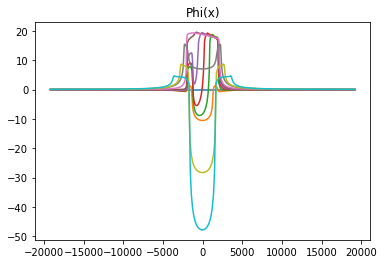

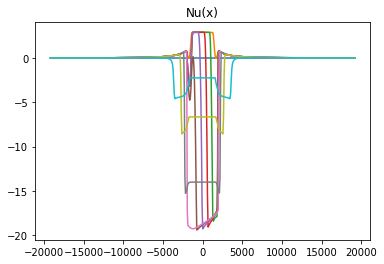

In [101]:
##Affichage
pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, Phi[n])
plt.title('Phi(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x, Nu[n])
plt.title('Nu(x)')
plt.show()

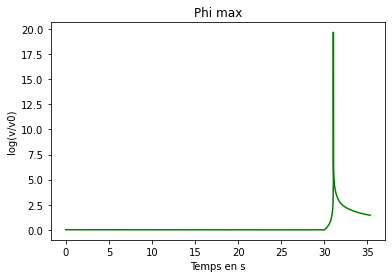

In [102]:
Mphi = np.array([np.max(f) for f in Phi])

plt.plot(temps, Mphi, color='g')
plt.title('Phi max')
plt.xlabel('Temps en s')
plt.ylabel('log(v/v0)')
plt.show()

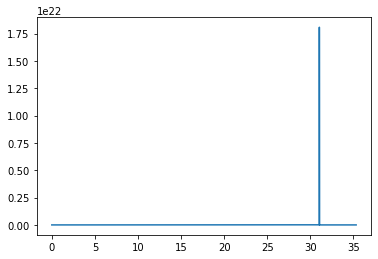

Magnitude = 19.841617161196826


In [157]:
vseuil = 1e-2

U = scipy.integrate.simps(np.exp(Phi), x)
U = mu*U

pos = U < vseuil*mu*deltaX
V = U.copy()
V[pos] = 0

M0 = scipy.integrate.simps(V, temps)
Mw = 2/3*np.log(M0)-6

plt.plot(temps, U)
plt.show()
print('Magnitude = ' + str(Mw))